In [1]:
from functools import partial

import jax
from jax import random
import numpyro
import xarray as xr
from jax import numpy as jnp
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from numpyro import handlers

from src.data_loading import load_data
from src.preprocessing.preprocessing import (
    XArrayStandardScaler,
    XArrayFeatureUnion,
    SeasonalFeatures,
)
from src.utils import flatten_array
import arviz as az
import matplotlib.pyplot as plt

numpyro.set_platform("cuda")
numpyro.set_host_device_count(1)

/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X = (
    load_data(["precip", "temp", "evap"])
    .sel(type=["Basin", "Land", "Water"])
    # .sel(type=["Water", ])
    .dropna("Date")
    .to_array()
    .transpose("Date", "lake", ...)
    # .sel(Date=slice("1980", "1990"))
)
X

KeyboardInterrupt: 

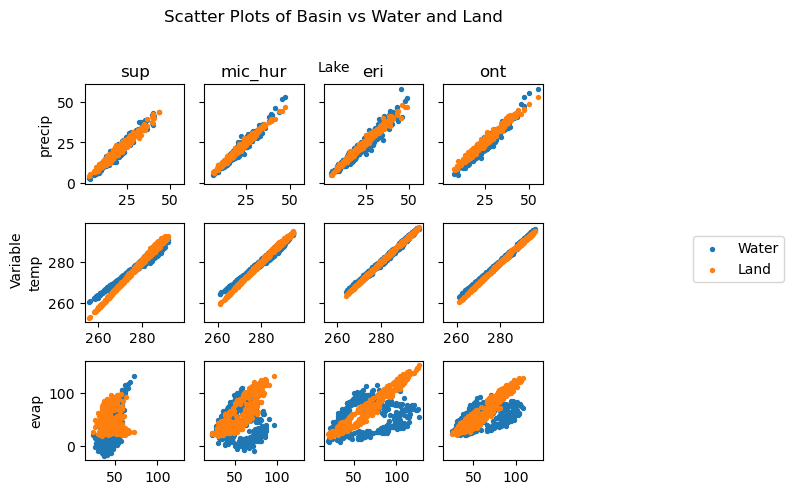

In [83]:
fig, ax = plt.subplots(3, 4, sharex="row", sharey="row")
handles, labels = [], []

for i, arr in enumerate(X.transpose("variable", ...)):
    for j, inner_arr in enumerate(arr.transpose("lake", ...)):
        scatter_water = ax[i, j].scatter(inner_arr.sel(type="Basin"), inner_arr.sel(type="Water"), label="Water", s=8)
        scatter_land = ax[i, j].scatter(inner_arr.sel(type="Basin"), inner_arr.sel(type="Land"), label="Land", s=8)
        
        if i == 0 and j == 0:  # Collect handles and labels only once
            handles.extend([scatter_water, scatter_land])
            labels.extend([scatter_water.get_label(), scatter_land.get_label()])

        if i == 0:  # Set titles for the top row
            ax[i, j].set_title(X.indexes["lake"][j])
        if j == 0:  # Set y-labels for the left column
            ax[i, j].set_ylabel(X.indexes["variable"][i])

# Add a global legend outside the plot area on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

# Add super titles for the axes
fig.suptitle('Scatter Plots of Basin vs Water and Land', y=1.02)
fig.text(0.5, 0.90, 'Lake', ha='center', va='center')
fig.text(0.005, 0.5, 'Variable', ha='center', va='center', rotation='vertical')

fig.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

TypeError: FigureBase.text() got multiple values for argument 's'

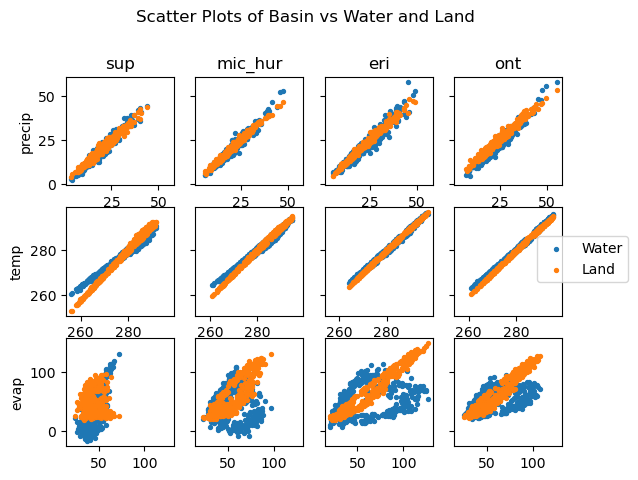

In [98]:
fig, ax = plt.subplots(3, 4, sharex="row", sharey="row")
handles, labels = [], []

for i, arr in enumerate(X.transpose("variable", ...)):
    for j, inner_arr in enumerate(arr.transpose("lake", ...)):
        scatter_water = ax[i, j].scatter(inner_arr.sel(type="Basin"), inner_arr.sel(type="Water"), label="Water", s=8)
        scatter_land = ax[i, j].scatter(inner_arr.sel(type="Basin"), inner_arr.sel(type="Land"), label="Land", s=8)
        
        if i == 0 and j == 0:  # Collect handles and labels only once
            handles.extend([scatter_water, scatter_land])
            labels.extend([scatter_water.get_label(), scatter_land.get_label()])

        if i == 0:  # Set titles for the top row
            ax[i, j].set_title(X.indexes["lake"][j])
        if j == 0:  # Set y-labels for the left column
            ax[i, j].set_ylabel(X.indexes["variable"][i])

# Add a global legend outside the plot area on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1)

# Add super titles for the axes
fig.suptitle('Scatter Plots of Basin vs Water and Land', y=1.02)
fig.text(0.5, 0.94, 'Lake', ha='center', va='center')
fig.text(0.005, 0.5, 'Variable', ha='center', va='center', rotation='vertical')

fig.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [6]:
y, x = xr.align(load_data("rnbs"), X)
y = jnp.array(y)

preprocessor = Pipeline(
    [
        (
            "features",
            XArrayFeatureUnion(
                [
                    (
                        "preprocess",
                        Pipeline(
                            steps=[
                                ("flatten_array", FunctionTransformer(flatten_array)),
                                ("scale", XArrayStandardScaler()),
                                # ("pca", PCA(n_components=5))
                            ]
                        ),
                    ),
                    ("seasonal", SeasonalFeatures()),
                ]
            ),
        ),
        ("array", FunctionTransformer(jnp.array)),
    ]
)


train_x, test_x, train_y, test_y = x[:-36], x[-36:], y[:-36], y[-36:]

y_scaler = StandardScaler()
train_y = jnp.array(y_scaler.fit_transform(train_y))

scaled_x = preprocessor.fit_transform(train_x)
scaled_x, train_y

(Array([[-8.5780394e-01, -1.2729377e+00, -3.2368720e-01, ...,
          3.3394405e-01,  5.0000000e-01,  8.6602539e-01],
        [-3.5136759e-01, -5.9431070e-01, -8.8323556e-02, ...,
         -1.7323083e-01,  8.6602539e-01,  5.0000000e-01],
        [ 2.3092477e+00,  2.3334796e+00,  2.1922688e+00, ...,
         -1.7909642e+00,  1.0000000e+00,  6.1232343e-17],
        ...,
        [ 2.9426579e+00,  2.7033687e+00,  3.0728536e+00, ...,
          2.5436392e-01, -8.6602539e-01,  5.0000000e-01],
        [-2.2001521e-01, -3.8550243e-01, -7.2091579e-02, ...,
          1.1101472e+00, -5.0000000e-01,  8.6602539e-01],
        [ 4.9950388e-01,  4.3779880e-01,  5.9883004e-01, ...,
          5.8634371e-01, -2.4492937e-16,  1.0000000e+00]], dtype=float32),
 Array([[-1.2070606 , -0.4801649 ,  0.1162767 ,  0.73868334],
        [-0.4148847 , -0.49179608,  0.5945408 , -0.45654318],
        [ 1.1272259 ,  2.2614212 ,  1.8176426 ,  2.4223487 ],
        ...,
        [ 2.0713782 , -0.82773554, -1.6239779 , -1.

In [7]:
# squared exponential kernel with diagonal noise term
def rbf_kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    r = jnp.linalg.norm(X[:, None] - Z, axis=-1)
    k = var * jnp.exp(-jnp.power(r / (jnp.sqrt(2) * length), 2))
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def matern_kernel(
    X, Z, var, length, noise, nu=3 / 2, jitter=1.0e-6, include_noise=True
):
    r = jnp.linalg.norm(X[:, None] - Z, axis=-1)
    if nu == 1 / 2:
        k = var * jnp.exp(-jnp.power(r / (jnp.sqrt(2) * length), 2))
    elif nu == 3 / 2:
        k = var * (1 + jnp.sqrt(3) * r / length) * jnp.exp(-jnp.sqrt(3) * r / length)
    elif nu == 5 / 2:
        k = (
            var
            * (1 + jnp.sqrt(5) * r / length + 5 * r**2 / (3 * length**2))
            * jnp.exp(-jnp.sqrt(5) * r / length)
        )
    else:
        raise ValueError("nu must be 1/2 or 3/2")

    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def rq_kernel(X, Z, alpha, length, noise, jitter=1.0e-6, include_noise=True):
    r = jnp.linalg.norm(X[:, None] - Z, axis=-1)
    k = (1 + r**2 / (2 * alpha * length**2)) ** (-alpha)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


kernel_fn = partial(matern_kernel, nu=3 / 2)

kernel_fn(scaled_x, scaled_x, 1, 1, 1)

Array([[2.0000010e+00, 3.7401864e-05, 1.5475632e-06, ..., 1.9556893e-08,
        1.7276424e-04, 4.1417270e-03],
       [3.7401864e-05, 2.0000010e+00, 4.2069287e-06, ..., 2.8721356e-08,
        1.5947748e-05, 4.3559999e-06],
       [1.5475632e-06, 4.2069287e-06, 2.0000010e+00, ..., 1.6688018e-05,
        2.9865430e-06, 5.6205059e-05],
       ...,
       [1.9556893e-08, 2.8721356e-08, 1.6688018e-05, ..., 2.0000010e+00,
        2.5088115e-05, 1.5954960e-06],
       [1.7276424e-04, 1.5947748e-05, 2.9865430e-06, ..., 2.5088115e-05,
        2.0000010e+00, 1.1395039e-03],
       [4.1417270e-03, 4.3559999e-06, 5.6205059e-05, ..., 1.5954960e-06,
        1.1395039e-03, 2.0000010e+00]], dtype=float32)

In [68]:
def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.HalfNormal(1))
    noise = numpyro.sample("kernel_noise", dist.HalfNormal(3.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0, 2.0))

    n_lakes = Y.shape[1]
    with numpyro.plate("lake_plate", n_lakes):
        var_l = numpyro.sample("kernel_var_l", dist.HalfNormal(var))
        noise_l = numpyro.sample("kernel_noise_l", dist.HalfNormal(noise))
        length_l = numpyro.sample("kernel_length_l", dist.LogNormal(length, 2.0))

    # compute kernel
    cov_matrices = [
        kernel_fn(X, X, var_l[i], length_l[i], noise_l[i]) for i in range(n_lakes)
    ]

    y_lakes = [
        numpyro.sample(
            f"y{i}",
            dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
            obs=Y[:, i],
        )
        for i, k in enumerate(cov_matrices)
    ]

    numpyro.deterministic("y", jnp.stack(y_lakes, axis=-1))


def predict(rng_key, X, Y, X_test, var, length, noise, use_cholesky=True):
    # compute kernels between train and test data, etc.
    k_pp = kernel_fn(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel_fn(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel_fn(X, X, var, length, noise, include_noise=True)

    # since K_xx is symmetric positive-definite, we can use the more efficient and
    # stable Cholesky decomposition instead of matrix inversion
    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), 0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

TypeError: jit() missing 1 required positional argument: 'fun'

In [11]:
# demonstrate how to use different HMC initialization strategies
kernel = NUTS(model)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=500,
    num_chains=4,
)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, scaled_x, train_y)
mcmc.get_samples()

/tmp/ipykernel_216379/3828102236.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [01:20<00:00, 18.69it/s, 15 steps of size 2.82e-01. acc. prob=0.89]


{'kernel_length': Array([2.3372793, 1.5708593, 1.656552 , ..., 2.5050907, 3.6916244,
        1.2530103], dtype=float32),
 'kernel_length_l': Array([[16.025217, 33.921234, 18.815466, 16.786531],
        [20.306732, 24.018833, 14.024453, 16.285255],
        [24.284058, 23.380102, 15.445851, 13.645929],
        ...,
        [28.806044, 15.886453, 32.06613 , 12.103965],
        [26.120691, 15.669294, 24.20939 , 13.409929],
        [20.91837 , 26.155912, 16.124748, 13.901088]], dtype=float32),
 'kernel_noise': Array([0.45494583, 0.10783366, 0.21620184, ..., 0.29978764, 0.444396  ,
        0.17657116], dtype=float32),
 'kernel_noise_l': Array([[0.08813163, 0.09019937, 0.14218031, 0.14370199],
        [0.0950129 , 0.10287874, 0.11258736, 0.13213867],
        [0.11514387, 0.08818848, 0.12841475, 0.13843057],
        ...,
        [0.11157064, 0.09314171, 0.13825265, 0.11893035],
        [0.10227747, 0.08663267, 0.11360864, 0.11447051],
        [0.09621365, 0.09162135, 0.14042781, 0.12081085]], 

array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>],
       [<Axes: title={'center': 'kernel_length'}>,
        <Axes: title={'center': 'kernel_length'}>],
       [<Axes: title={'center': 'kernel_noise'}>,
        <Axes: title={'center': 'kernel_noise'}>],
       [<Axes: title={'center': 'kernel_var_l'}>,
        <Axes: title={'center': 'kernel_var_l'}>],
       [<Axes: title={'center': 'kernel_length_l'}>,
        <Axes: title={'center': 'kernel_length_l'}>],
       [<Axes: title={'center': 'kernel_noise_l'}>,
        <Axes: title={'center': 'kernel_noise_l'}>]], dtype=object)

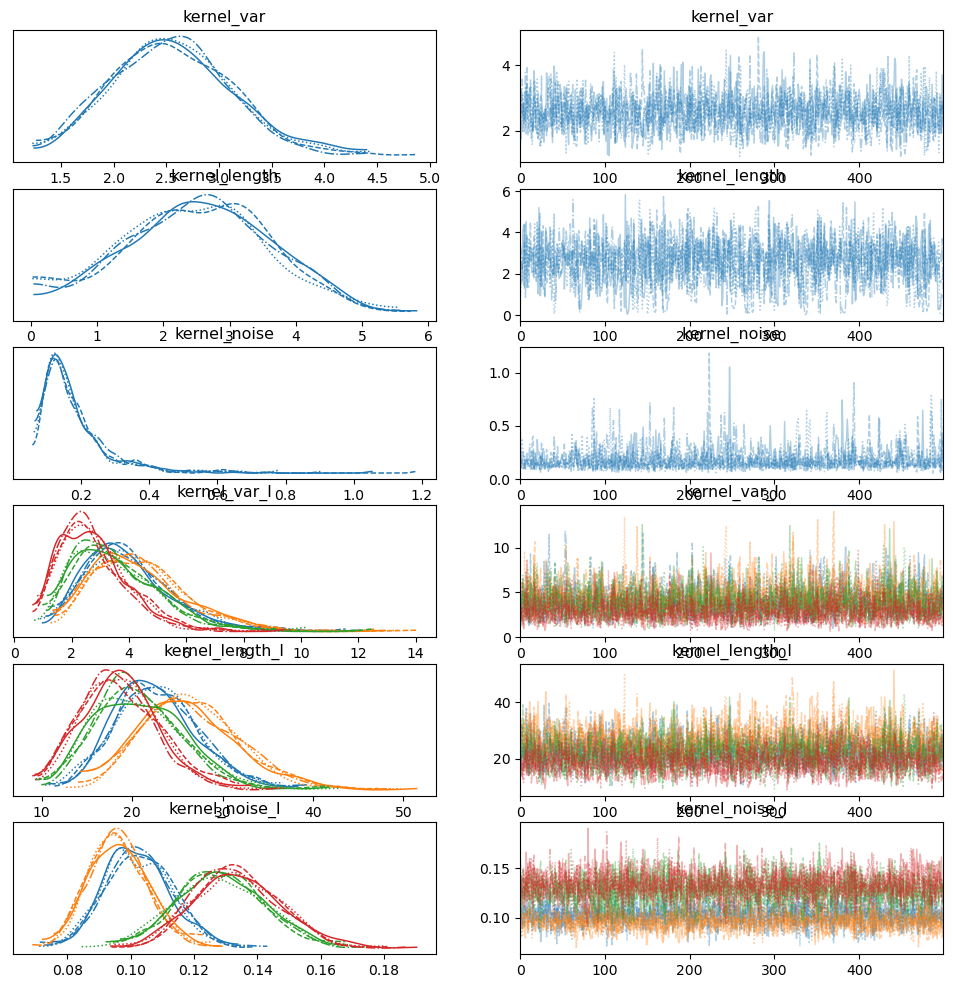

In [46]:
trace = az.from_numpyro(mcmc)

az.plot_trace(
    trace,
    var_names=[
        "kernel_var",
        "kernel_length",
        "kernel_noise",
        "kernel_var_l",
        "kernel_length_l",
        "kernel_noise_l",
    ],
)

In [2]:
rng_key_predict = jax.random.PRNGKey(22)
samples = mcmc.get_samples()

scaled_test_x = preprocessor.transform(test_x)
scaled_test_y = y_scaler.transform(test_y)

# {
#     v.to_devicesamples
# }

cpus = jax.devices("cpu")
predict_fn = jax.jit(predict, device=jax.devices("cpu")[0])
# samples["kernel_var"].to_device(cpu_device)

vmap_args = (
    random.split(rng_key_predict, (samples["kernel_var"].shape[0], 4)),
    scaled_x,
    train_y,
    scaled_test_x,
    samples["kernel_var_l"],
    samples["kernel_length_l"],
    samples["kernel_noise_l"],
)

means, predictions = jax.vmap(
    jax.vmap(predict_fn, in_axes=(0, None, None, None, 0, 0, 0)),
    in_axes=(1, None, 1, None, 1, 1, 1),
)(*vmap_args)

NameError: name 'jax' is not defined

In [1]:
means.shape

NameError: name 'means' is not defined

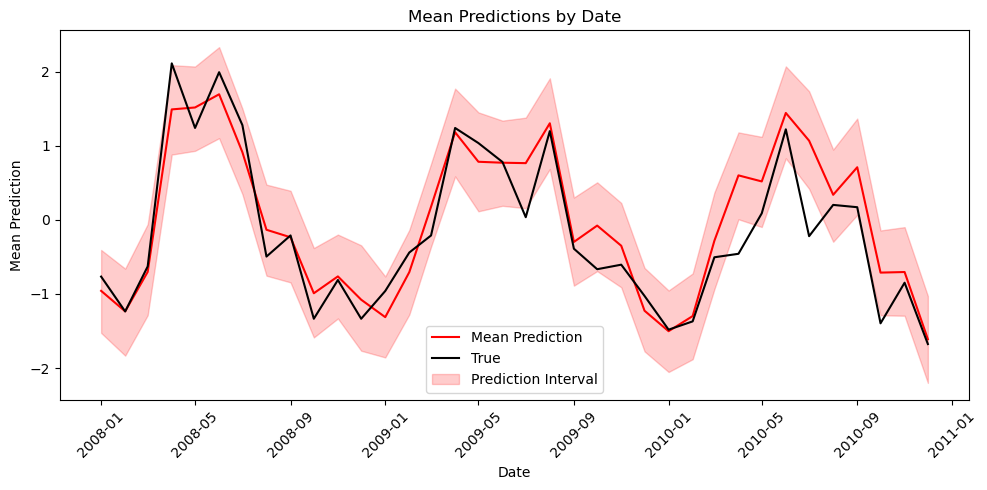

In [29]:
# fig, ax = plt.subplots(1)

plot_x, plot_y = test_x.indexes["Date"].values, mean_prediction

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(plot_x, plot_y, label="Mean Prediction", color="red")
plt.plot(plot_x, scaled_test_y, label="True", color="black")
plt.fill_between(
    plot_x,
    percentiles[0],
    percentiles[1],
    color="red",
    alpha=0.2,
    label="Prediction Interval",
)

# # Add labels and title
plt.xlabel("Date")
plt.ylabel("Mean Prediction")
plt.title("Mean Predictions by Date")
plt.legend()

# # Rotate date labels for better readability
plt.xticks(rotation=45)

# # Display the plot
plt.tight_layout()
plt.show()

# # mean_prediction